# Initial Exploratory NLP Analysis of Reddit Searches

Using the raw data scraped by PRAW: The Python Reddit API Wrapper, the titles and post descriptions are combined, cleaned, and turned into bi-grams. The list of bi-grams is then listed by count and put into a bar graph. The raw data was created by searching certain subreddits with a certain search term:

        Sub-Reddit, search term
        ('LosAngeles', 'parking'), 
        ('all', 'Los Angeles parking'),
        ('LosAngeles', 'parking regulation'),
        ('all', 'Los Angeles parking regulation')]

In [1]:
# Import libraries and set directory
import pandas as pd
import numpy as np
import nltk
from pathlib import Path
import os
from typing import Union
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

PROJECT_DIR = Path(os.path.abspath('')).resolve().parents[0]

In [2]:
# Download NLTK libaries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /home/greg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/greg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Examine raw data structure
all_la_pk_reg = pd.read_json(PROJECT_DIR / 'data/raw/ALLla_parking_regulation.json')
all_la_pk_reg.head()

,title,permalink,selftext,upvote_ratio,url,votes
0,[Los Angeles] Looks like LADOT parking regulat...,/r/SoCalCoronavirus/comments/hamtea/los_angele...,,1.00,https://www.facebook.com/ladotofficial/photos/...,14
1,[Los Angeles] - List of Certain Parking Regula...,/r/SoCalCoronavirus/comments/gnmcng/los_angele...,Per Councilman Huizar:\n\nConsistent with exte...,1.00,https://www.reddit.com/r/SoCalCoronavirus/comm...,2
2,Valet parking regulations to be considered by ...,/r/LosAngeles/comments/13epqd/valet_parking_re...,,0.96,http://www.latimes.com/news/local/la-me-valet-...,17
3,Gov. Newsom Signs Law Clearing Way for Regulat...,/r/kawaraban/comments/c60r8w/gov_newsom_signs_...,,1.00,https://ktla.com/2019/06/26/gov-newsom-signs-n...,1
4,@NBCNews: Santa Anita Park near Los Angeles re...,/r/newsbotbot/comments/bytl1d/nbcnews_santa_an...,,1.00,https://mobile.twitter.com/NBCNews/status/1137...,1


In [4]:
# Function that creates list of bi- or tri-grams, 
def create_grams(input_file: Union[str, Path], gram: str='bi') -> list: 
    ''' Takes input file path and combines title and self_text columns,
    tokenizes, removes stopwords, lemmatizes, and looks for either bi- or
    tri-grams and puts it all in one list.
    '''

    # Read file into DataFrame
    df = pd.read_json(input_file)

    # Combine title and self_text
    df['title_selftext'] = df['title'] + df['selftext']

    # Change all words into lowercase
    df['title_selftext'] = df['title_selftext'].apply(lambda x: x.lower())

    # Tokenize
    df['tokens'] = df.title_selftext.apply(lambda x: 
            nltk.RegexpTokenizer(r'\w+').tokenize(x))

    # Remove stop words and lemmatize using WordNetLemmatizer
    wnl = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [wnl.lemmatize(w) 
            for w in x if not w in stop_words])

    # Apply bigram, trigram, or error
    if gram=='bi':
        df['grams'] = df['tokens'].apply(nltk.bigrams)
    elif gram=='tri':
        df['grams'] = df['tokens'].apply(nltk.trigrams)
    else:
        raise NameError('Only bi or tri allowed')

    # Return combined list of bi-grams
    return [' '.join(item) for sublist in df.grams for item in sublist]



In [5]:
# Apply create_grams to all raw data and count bi-grams
bigram_list = []
for path in (PROJECT_DIR / 'data' / 'raw').glob("*.json"):
    bigram_list = bigram_list + create_grams(path)
    combined_bigrams = pd.Series(bigram_list)
biggram_counts = combined_bigrams[combined_bigrams.str.contains('parking')].value_counts()
biggram_counts[:10]

parking enforcement    91
angeles parking        91
parking lot            90
parking regulation     34
relaxed parking        27
parking fine           23
parking garage         21
parking ticket         20
parking restriction    19
parking spot           19
dtype: int64

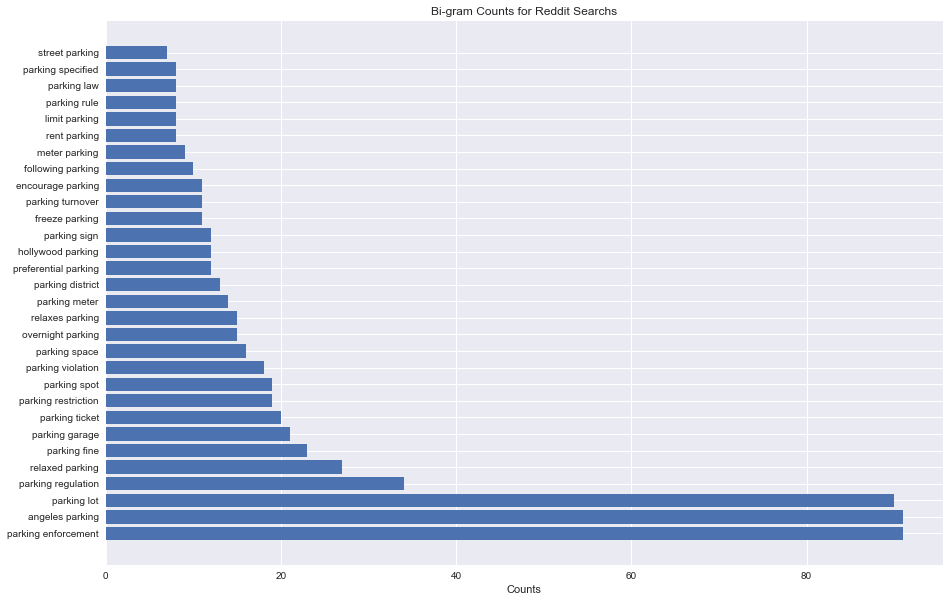

In [6]:
# Plot top 30 bi-grams
plt.figure(figsize=(15,10))
plt.style.use('seaborn')
plt.barh(biggram_counts[:30].index, biggram_counts[:30].values)
plt.title('Bi-gram Counts for Reddit Searchs')
plt.xlabel('Counts')
plt.savefig(PROJECT_DIR / 'reports/figures' / 'tot_bigram_bar.png')

In [7]:
# Apply create_grams to all raw data and count tri-grams
trigram_list = []
for path in (PROJECT_DIR / 'data' / 'raw').glob("*.json"):
    trigram_list = trigram_list + create_grams(path, gram='tri')
    combined_trigram = pd.Series(trigram_list)
trigram_counts = combined_trigram[combined_trigram.str.contains('parking')].value_counts()
trigram_counts[:10]

los angeles parking              91
angeles parking lot              23
angeles parking enforcement      20
relaxed parking enforcement      20
parking enforcement http         19
parking lot november             13
relaxes parking enforcement      13
parking fine increase            12
preferential parking district    12
vehicle overnight parking        12
dtype: int64

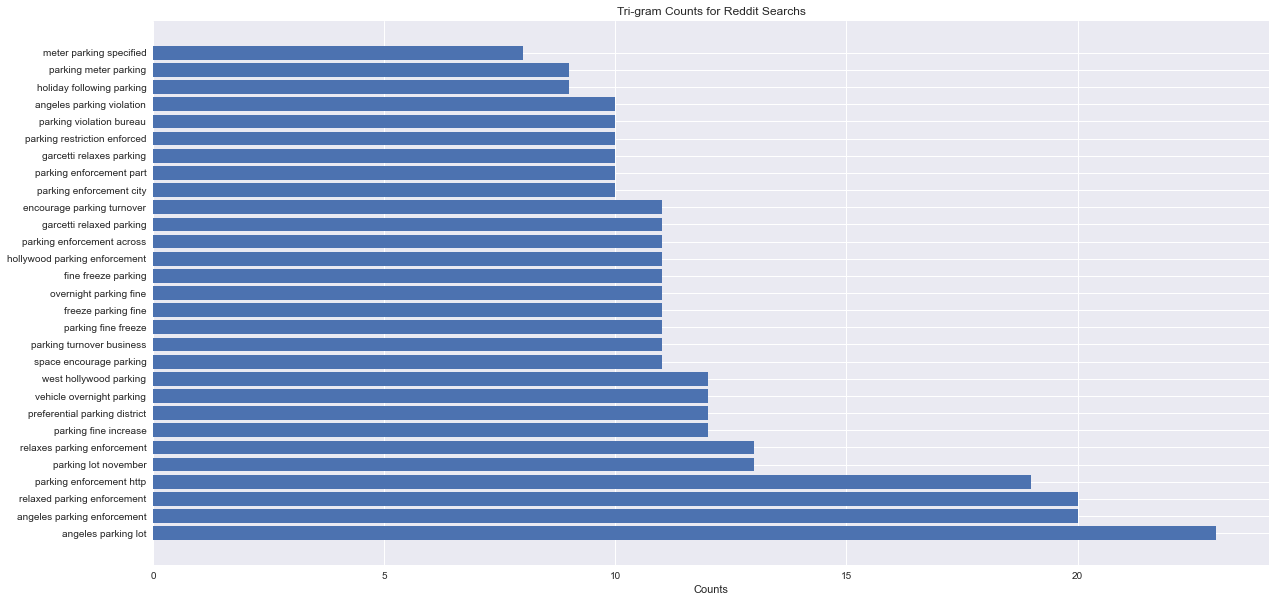

In [8]:
# Plot top 30 tri-grams
# Removed first result "los angeles parking"
plt.figure(figsize=(20,10))
plt.style.use('seaborn')
plt.barh(trigram_counts[1:30].index, trigram_counts[1:30].values)
plt.title('Tri-gram Counts for Reddit Searchs')
plt.xlabel('Counts')
plt.savefig(PROJECT_DIR / 'reports/figures' / 'tot_trigram_bar.png')